# Introduction to T<sub>c</sub>1D (Inverse mode)

This is a Jupyter notebook, an interactive web application, that can be used to run numerical simulations using the T<sub>c</sub>1D software in inverse mode.

# Inversion of Thermochronological Data with T<sub>c</sub>1D

Thermochronology provides quantitative constraints on the cooling history of rocks through geological time. These data are used to infer the timing and rate of processes such as exhumation and burial. However, the relationship between the geological parameters (e.g., erosion history) and the observed thermochronological ages is complex and non-linear. Therefore, you need to solve an inverse problem: finding the set of model parameters that best reproduce the observed data.

## What is an Inversion?

An inversion explores possible model parameters and selects those that, when used in forward simulations, generate synthetic data consistent with the observations. In practice, we compare observed and predicted thermochronological ages to quantify the model misfit. Inversion problems are often non-unique and can present multiple acceptable solutions, which is why we explore the parameter space systematically.

## Inversion Methods in T<sub>c</sub>1D

This notebook illustrates two popular approaches for exploring the parameter space and performing inversions with the T<sub>c</sub>1D software:

### 1. Neighbourhood Algorithm (NA)

- A stochastic, adaptive sampling method.
- It iteratively explores the parameter space by favoring regions of lower misfit.
- It efficiently identifies acceptable models but does not provide a formal probability distribution.

### 2. Markov Chain Monte Carlo (MCMC)

- A Bayesian, probabilistic method based on random walks.
- It samples the parameter space proportionally to the likelihood of each model.
- It allows full statistical characterization of the uncertainties but is often computationally more expensive.

> ⚠️ **Disclaimer**
>
> The inversions performed in this notebook are simplified and use a limited number of parameters, reduced model complexity, and small sampling sizes. This is done intentionally to ensure rapid execution and allow interactive exploration within a Jupyter notebook environment. The results shown here are purely illustrative and do not represent a scientifically valid interpretation of real thermochronological datasets. For rigorous scientific applications, inversions should be performed with appropriately complex models, realistic parameter ranges, and sufficient sampling to ensure robust exploration of the parameter space.

## Objective of this Notebook

We will use T<sub>c</sub>1D to perform both NA and MCMC inversions on a simple dataset. The goal is to illustrate how these methods work and how to visualize and interpret the results.


## Attribution

If you use plots produced by this software, please cite the following:

- D. Whipp. (2022). HUGG/TC1D: v0.1 (v0.1). Zenodo. https://doi.org/10.5281/zenodo.7124272.

The age prediction software used for calculating apatite and zircon (U-Th)/He and apatite fission-track ages was written by Richard Ketcham at the University of Texas, USA. Results published using this software should cite the articles below:

- Ketcham, R. A., Donelick, R. A., & Carlson, W. D.: Variability of apatite fission-track annealing kinetics III: Extrapolation to geological time scales. American Mineralogist, 84, 1235-1255, doi: [10.2138/am-1999-0903](https://doi.org/10.2138/am-1999-0903), 1999.

- Ketcham, R. A., Mora, A., and Parra, M.: Deciphering exhumation and burial history with multi-sample down-well thermochronometric inverse modelling, Basin Res., 30, 48-64, [10.1111/bre.12207](https://doi.org/10.1111/bre.12207), 2018.

# Using this notebook

It is easy to get started reproducing or customizing versions of the plots using this notebook. Below you will find some general information about the notebook environment and examples of each plot from the article.

## Using a Jupyter notebook

A Jupyter notebook is a document that combines rich text formatting (like that in a word processor or website) with programming language code. The notebook itself is divided into blocks called cells that have a defined cell type, which means a cell can either contain rich text, code, or raw unformatted text (but not a mix). For us, the main concern will be code cells and how to run them, as that will be the way to produce a plot.

### Running a code cell

There are two options for running a code cell.

1. Click on the cell containing code and press one of the following key combinations:

    - <kbd>shift</kbd> + <kbd>enter</kbd> or 
    - <kbd>shift</kbd> + <kbd>return</kbd>

    On a Mac keyboard the <kbd>shift</kbd> keys have arrows pointing up and the <kbd>return</kbd> is on the far right with a bent arrow pointing left.

2. Select a cell containing code and press the play button (▶︎) in the toolbar.

Let's test this out with an example below, just to make sure the environment is working. Click on the code cell below and then press <kbd>shift</kbd> + <kbd>enter</kbd> or <kbd>shift</kbd> + <kbd>return</kbd> to run it.

## Using Binder

[Binder](https://mybinder.org/) is a cloud computing platform that provides the computing used to run a Jupyter notebook free of charge. You are most likely using Binder right now if you have opened this notebook and the code example above works. You don't really need to know much about Binder in order to use it, however, there is one important note about Binder: **Your session will die and your notebook will stop functioning after about 10 minutes of inactivity**. This means you may lose any progress you have made in the notebook after this time elapses. If you want to keep your session alive, be sure to run at least one code cell every 10 minutes. Once the session dies...

You can find more information about Binder in the [Binder user guide](https://mybinder.readthedocs.io/en/latest/index.html).

# Running T<sub>c</sub>1D inversion using the Neighbourhood algorithm (NA)

With the necessary background out of the way we can now move forward to running a first inversion.

## Preparing to run an inversion

Before starting, **you must run the code cell below first** to load the T<sub>c</sub>1D code into memory. Note that lines starting with the `#` character are comment lines that can be used for documentation, but are not executed as Python commands.

In [10]:
# import TC1D
import sys
sys.path.append('tc1d')
import tc1d

## Synthetic Thermochronology Dataset

The table obtained with the command line below presents a simple synthetic dataset that will be used for demonstration purposes in this notebook. It includes a combination of commonly used low-temperature thermochronometers:

- **AHe**: Apatite (U-Th)/He
- **AFT**: Apatite Fission Tracks
- **ZHe**: Zircon (U-Th)/He
- **ZFT**: Zircon Fission Tracks

For each sample, we provide:

- The measured age (in millions of years, Ma)
- The standard deviation of the age (representing uncertainty)
- The effective Uranium (eU) concentration for (U-Th)/He samples
- The grain radius for (U-Th)/He samples
- A sample ID for identification

Note that missing values (`NaN`) correspond to information not relevant for the specific thermochronometer (e.g., eU and grain radius are not applicable to fission track samples).

In [11]:
# import data
import pandas as pd
data_file = "tc1d/csv/sample_data.csv"
df = pd.read_csv(data_file)
df

,Age type,Age (Ma),Standard deviation (Ma),eU concentration (ppm),Grain radius (um),Sample ID
0,AHe,2.74,0.3,29.3,58.0,demo1
1,AFT,5.98,0.6,NaN,NaN,demo2
2,ZHe,8.15,0.6,506.8,57.9,demo3
3,ZFT,9.80,0.9,NaN,NaN,demo4


## Running a Neighbourhood Algorithm (NA) Inversion

The following code cell performs an inversion of the synthetic dataset using the Neighbourhood Algorithm (NA) implemented in T<sub>c</sub>1D. The process should take few minutes.

The inversion is launched via a command-line call to the `tc1d_cli.py` script, specifying:

- The erosion model type (`--ero-type`)
- The erosion history parameters (`--ero-option1` to `--ero-option4`)
- The total model time and time step (`--time`, `--dt`)
- The input dataset (`--obs-age-file`)
- The inversion mode (`NA` in this case)

Once the inversion is complete, a series of plots are generated and saved in the current directory. The cell then displays these plots directly in the notebook for easy inspection:

- **Misfit plot**: model misfit evolution
- **Scatter plot**: parameter space exploration
- **Covariance matrix**: parameter correlation structure
- **Voronoi plot**: visualization of NA sampling

### Example Inversion Parameters

The inversion performed in this example uses the following erosion history parameters and model configuration:

| Parameter         | Value(s)      | Description                                  |
|-------------------|---------------|----------------------------------------------|
| `--ero-type`      | 2             | Erosion model type                           |
| `--ero-option1`   | 0.0 to 15.0   | First erosion magnitude: parameter range (km)    |
| `--ero-option2`   | 6.0           | First erosion event: fixed time (Ma) between 0 and 6 Myrs        |
| `--ero-option3`   | 0.0 to 15.0   | Second erosion magnitude: parameter range (km)    |
| `--ero-option4`   | 12.0          | Second erosion event: fixed time (Ma) between 6 and 12 Myrs       |
| `--time`          | 12.0          | Total model time (Ma)                        |
| `--dt`            | 20000         | Time step for forward model (years)          |
| `--obs-age-file`  | `tc1d/sample_data.csv` | Path to input dataset                     |
| `--inverse-mode`  | NA            | Inversion mode: Neighbourhood Algorithm      |

**Note**: Some parameters are defined as ranges (e.g., `0.0 to 15.0`) to allow the inversion algorithm to explore possible values within those limits. Other parameters are fixed.

### Neighbourhood Algorithm (NA) Settings

The Neighbourhood Algorithm (NA) is a stochastic, adaptive search method designed to efficiently explore parameter space in inverse problems.

In the T<sub>c</sub>1D code, the NA is configured using the `NASearcher` class from the `neighpy` package. The main parameters controlling the inversion are defined directly in the `tc1d.py` script.

Below is a description of the key NA settings used in this example:

| Parameter | Value | Description                                                      |
|------------|-------|------------------------------------------------------------------|
| `ns`       | 60    | Number of samples per iteration (controls how many new models are generated in each iteration) |
| `nr`       | 30    | Number of cells to resample (determines how many of the lowest misfit regions are preferentially explored) |
| `ni`       | 120   | Number of initial random samples (controls the size of the initial exploration phase) |
| `n`        | 10     | Number of iterations of the algorithm (total number of NA steps performed) |

The parameter `bounds` defines the limits of the parameter space for the inversion (ranges for erosion events in this case).

**Important**: To modify these NA settings, you need to edit the source code of the `tc1d.py` script directly. These parameters are hard-coded for simplicity in this notebook example.

--- Starting batch processor for 4 models ---

--- Starting inverse mode ---

NAI - Initial Random Search
 The current values are: {'ero_option1': 3.2350863270582737, 'ero_option3': 5.0393439105079265}
.......... The current misfit is: 0.9693410818378413

 The current values are: {'ero_option1': 13.81727625925425, 'ero_option3': 14.351969540068529}
.......... The current misfit is: 4.191823986878206

 The current values are: {'ero_option1': 12.057313064793862, 'ero_option3': 0.5553317852082879}
.......... The current misfit is: 3.593459333624869

 The current values are: {'ero_option1': 6.829371448384676, 'ero_option3': 2.5650022283368754}
.......... The current misfit is: 2.7866806951267002

 The current values are: {'ero_option1': 5.350942447762728, 'ero_option3': 5.129484445750761}
.......... The current misfit is: 0.6882002666581603

 The current values are: {'ero_option1': 7.742378644355278, 'ero_option3': 3.9718877602608442}
.......... The current misfit is: 1.1637119817707642

 

NAI - Optimisation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

 The current values are: {'ero_option1': 5.648791137649914, 'ero_option3': 5.173666078974752}
.......... The current misfit is: 0.6955753777356138

 The current values are: {'ero_option1': 5.272014897713762, 'ero_option3': 5.034686555229714}
.......... The current misfit is: 0.7063064364479247

 The current values are: {'ero_option1': 2.513479428474696, 'ero_option3': 6.518982111116205}
.......... The current misfit is: 0.7126714481541301

 The current values are: {'ero_option1': 2.3463219208750354, 'ero_option3': 6.634205531736474}
.......... The current misfit is: 0.7468224882885112

 The current values are: {'ero_option1': 6.376225786472588, 'ero_option3': 4.886749964322377}
.......... The current misfit is: 0.7612195854129284

 The current values are: {'ero_option1': 6.141238734775264, 'ero_option3': 4.867915640085058}
.......... The current misfit is: 0.7584450256733085

 The current values are: {'ero_option1': 5.089056423258888, 'ero_option3': 4.819839370828738}
.......... The cu

NAI - Optimisation Loop:  10%|█         | 1/10 [00:28<04:12, 28.01s/it]

 The current misfit is: 1.6406042387397204

 The current values are: {'ero_option1': 5.476884743953308, 'ero_option3': 5.131286309852696}
.......... The current misfit is: 0.6924928813971408

 The current values are: {'ero_option1': 5.320450878751201, 'ero_option3': 5.082504053961754}
.......... The current misfit is: 0.6929943443086392

 The current values are: {'ero_option1': 5.811793151922838, 'ero_option3': 5.204015798181928}
.......... The current misfit is: 0.7068675052027203

 The current values are: {'ero_option1': 5.675674435099109, 'ero_option3': 5.232102109952324}
.......... The current misfit is: 0.6980915932373682

 The current values are: {'ero_option1': 5.302397626848729, 'ero_option3': 5.037900959896382}
.......... The current misfit is: 0.7080717441041046

 The current values are: {'ero_option1': 5.200345961677271, 'ero_option3': 5.032528841569768}
.......... The current misfit is: 0.7085711779232533

 The current values are: {'ero_option1': 2.6862483609418306, 'ero_op

NAI - Optimisation Loop:  20%|██        | 2/10 [00:54<03:36, 27.02s/it]

 The current misfit is: 1.1004646804869365

 The current values are: {'ero_option1': 2.685595979865601, 'ero_option3': 6.338871178692115}
.......... The current misfit is: 0.6524945082362884

 The current values are: {'ero_option1': 2.604261057097288, 'ero_option3': 6.179017450978876}
.......... The current misfit is: 0.5857522003133745

 The current values are: {'ero_option1': 5.400352309003706, 'ero_option3': 5.1277640072712645}
.......... The current misfit is: 0.6864394959755502

 The current values are: {'ero_option1': 5.37206894320394, 'ero_option3': 5.138530953174575}
.......... The current misfit is: 0.6867867876078696

 The current values are: {'ero_option1': 5.552012586462107, 'ero_option3': 5.129999116681821}
.......... The current misfit is: 0.6943342057582794

 The current values are: {'ero_option1': 5.433402462565453, 'ero_option3': 5.1270874910764475}
.......... The current misfit is: 0.6893677384038088

 The current values are: {'ero_option1': 5.331940257148801, 'ero_op

NAI - Optimisation Loop:  30%|███       | 3/10 [01:19<03:04, 26.36s/it]

........ The current misfit is: 0.5892663580051164

 The current values are: {'ero_option1': 2.582721607077708, 'ero_option3': 6.033152569242789}
.......... The current misfit is: 0.562740695563394

 The current values are: {'ero_option1': 2.6787515519890315, 'ero_option3': 6.299495803090076}
.......... The current misfit is: 0.6334285187038976

 The current values are: {'ero_option1': 2.6636878638496113, 'ero_option3': 6.319556826843165}
.......... The current misfit is: 0.6398911225964969

 The current values are: {'ero_option1': 2.693864169510129, 'ero_option3': 6.358944355154851}
.......... The current misfit is: 0.6616847609973736

 The current values are: {'ero_option1': 2.686998187483892, 'ero_option3': 6.3561934181281545}
.......... The current misfit is: 0.6595269768335542

 The current values are: {'ero_option1': 2.175896336704135, 'ero_option3': 6.550794549894319}
.......... The current misfit is: 0.6779257444829125

 The current values are: {'ero_option1': 2.179336217070233

NAI - Optimisation Loop:  40%|████      | 4/10 [01:45<02:37, 26.20s/it]

......... The current misfit is: 0.5632048040353678

 The current values are: {'ero_option1': 2.5432228430548154, 'ero_option3': 5.901047541126866}
.......... The current misfit is: 0.5755652607180636

 The current values are: {'ero_option1': 2.6157892399660625, 'ero_option3': 6.143536385306236}
.......... The current misfit is: 0.5779113003475965

 The current values are: {'ero_option1': 2.6051014571355053, 'ero_option3': 6.162025334355627}
.......... The current misfit is: 0.5812247180002182

 The current values are: {'ero_option1': 2.6499325872890944, 'ero_option3': 6.2074191342665195}
.......... The current misfit is: 0.5971811007797978

 The current values are: {'ero_option1': 2.625007217417644, 'ero_option3': 6.203315453540694}
.......... The current misfit is: 0.5936281499537236

 The current values are: {'ero_option1': 2.680849039988627, 'ero_option3': 6.243320898685496}
.......... The current misfit is: 0.6121582916187062

 The current values are: {'ero_option1': 2.68109943458

NAI - Optimisation Loop:  50%|█████     | 5/10 [02:11<02:10, 26.03s/it]

........ The current misfit is: 0.5633571631000227

 The current values are: {'ero_option1': 2.563156989749801, 'ero_option3': 5.967592405426021}
.......... The current misfit is: 0.5646328887375918

 The current values are: {'ero_option1': 2.596872658405962, 'ero_option3': 6.0624742711348105}
.......... The current misfit is: 0.5650756962527325

 The current values are: {'ero_option1': 2.5920569392465445, 'ero_option3': 6.075989942408825}
.......... The current misfit is: 0.5664777440722524

 The current values are: {'ero_option1': 2.5592830556854738, 'ero_option3': 5.878122392135735}
.......... The current misfit is: 0.5800533398668448

 The current values are: {'ero_option1': 2.508213703755277, 'ero_option3': 5.867336618322086}
.......... The current misfit is: 0.5883135728725432

 The current values are: {'ero_option1': 2.619531827360522, 'ero_option3': 6.092214211201091}
.......... The current misfit is: 0.5691513938323814

 The current values are: {'ero_option1': 2.61976849501667

NAI - Optimisation Loop:  60%|██████    | 6/10 [02:37<01:44, 26.06s/it]

....... The current misfit is: 0.5639026674734868

 The current values are: {'ero_option1': 2.5731061821734333, 'ero_option3': 6.022870913420107}
.......... The current misfit is: 0.5625859993213691

 The current values are: {'ero_option1': 2.590600480152056, 'ero_option3': 6.042374172496935}
.......... The current misfit is: 0.5637729170355138

 The current values are: {'ero_option1': 2.588521692227241, 'ero_option3': 6.045968724087901}
.......... The current misfit is: 0.5640104781670259

 The current values are: {'ero_option1': 2.5856118764887217, 'ero_option3': 6.00453549898388}
.......... The current misfit is: 0.562374618137181

 The current values are: {'ero_option1': 2.5794491154866623, 'ero_option3': 6.002324966178948}
.......... The current misfit is: 0.56232002956502

 The current values are: {'ero_option1': 2.5706315132010547, 'ero_option3': 5.936021208055606}
.......... The current misfit is: 0.5677173948617326

 The current values are: {'ero_option1': 2.570993415935747, '

NAI - Optimisation Loop:  70%|███████   | 7/10 [03:02<01:17, 25.80s/it]

 The current misfit is: 0.6188560514680413

 The current values are: {'ero_option1': 2.5806336668368313, 'ero_option3': 5.9983792837527465}
.......... The current misfit is: 0.5622902542243869

 The current values are: {'ero_option1': 2.5763805690534123, 'ero_option3': 5.98834902613308}
.......... The current misfit is: 0.5635733613502144

 The current values are: {'ero_option1': 2.5873379311711227, 'ero_option3': 6.0059098221937735}
.......... The current misfit is: 0.5626066168421943

 The current values are: {'ero_option1': 2.5859792188627693, 'ero_option3': 6.007152557301046}
.......... The current misfit is: 0.562736924407198

 The current values are: {'ero_option1': 2.5759250055687795, 'ero_option3': 6.021768774972324}
.......... The current misfit is: 0.5625194128013163

 The current values are: {'ero_option1': 2.5704525108621192, 'ero_option3': 6.021138123594617}
.......... The current misfit is: 0.5622548954775847

 The current values are: {'ero_option1': 2.582993175368242, 'e

NAI - Optimisation Loop:  80%|████████  | 8/10 [03:28<00:51, 25.81s/it]

 The current misfit is: 0.5785036370619456

 The current values are: {'ero_option1': 2.5824398630352112, 'ero_option3': 6.017693996238532}
.......... The current misfit is: 0.5621504716992235

 The current values are: {'ero_option1': 2.581044939926942, 'ero_option3': 6.015083909668109}
.......... The current misfit is: 0.5617407601838199

 The current values are: {'ero_option1': 2.571049079906247, 'ero_option3': 6.020206995171188}
.......... The current misfit is: 0.5621428822948782

 The current values are: {'ero_option1': 2.569520801232844, 'ero_option3': 6.020863200989232}
.......... The current misfit is: 0.562185915395719

 The current values are: {'ero_option1': 2.5817646344229543, 'ero_option3': 5.996463926513247}
.......... The current misfit is: 0.5637423370485959

 The current values are: {'ero_option1': 2.5802594953711013, 'ero_option3': 5.995992646611898}
.......... The current misfit is: 0.5636401710341605

 The current values are: {'ero_option1': 2.5797059521007135, 'ero_

NAI - Optimisation Loop:  90%|█████████ | 9/10 [03:53<00:25, 25.51s/it]

......... The current misfit is: 0.5618021732961148

 The current values are: {'ero_option1': 2.5802048783855245, 'ero_option3': 6.014460220307226}
.......... The current misfit is: 0.5635569564342704

 The current values are: {'ero_option1': 2.582221726145984, 'ero_option3': 6.016566956731917}
.......... The current misfit is: 0.5619850674649387

 The current values are: {'ero_option1': 2.581964776209945, 'ero_option3': 6.016886810220543}
.......... The current misfit is: 0.5620223846741582

 The current values are: {'ero_option1': 2.571417662469335, 'ero_option3': 6.0195935308728465}
.......... The current misfit is: 0.5620682067342884

 The current values are: {'ero_option1': 2.570842131720965, 'ero_option3': 6.019478470287358}
.......... The current misfit is: 0.5624189965209846

 The current values are: {'ero_option1': 2.5827367986443535, 'ero_option3': 6.01728235699861}
.......... The current misfit is: 0.5621019145896248

 The current values are: {'ero_option1': 2.58274740894600

NAII - Random Walk: 100%|██████████| 400/400 [00:00<00:00, 778.97it/s]


 The current misfit is: 0.5627297423915696

Appraiser mean: [7.16229479 6.19005281]
Appraiser mean error: [0.09529419 0.05881623]
Appraiser covariance: [[18.16196665 -2.95430641]
 [-2.95430641  6.91869709]]
Appraiser covariance error: [[0.37339357 0.25109889]
 [0.25109889 0.26394322]]
 The best parameters are: [2.58104494 6.01508391]

[NA] Misfit plot saved as: /Users/gerardb/Desktop/TC1D_demo_inversion/NA_misfit.png
[NA] Histograms saved as: /Users/gerardb/Desktop/TC1D_demo_inversion/NA_histograms.png
[NA] Scatter plot saved as: /Users/gerardb/Desktop/TC1D_demo_inversion/NA_scatter.png
[NA] Covariance matrix plot saved as: /Users/gerardb/Desktop/TC1D_demo_inversion/NA_covariance_matrix.png
[NA] Voronoi plot saved as: /Users/gerardb/Desktop/TC1D_demo_inversion/voronoi.png
Inverse mode complete

--- Execution complete (1 succeeded, 0 failed) ---


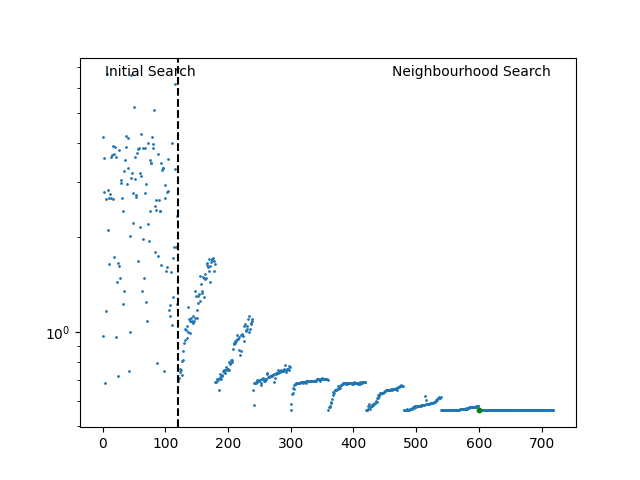

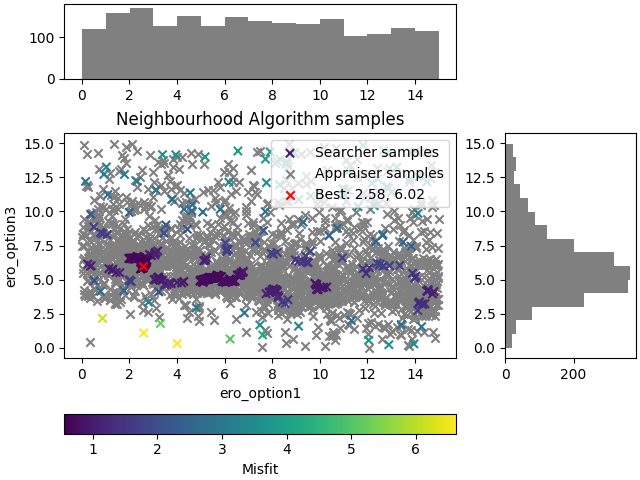

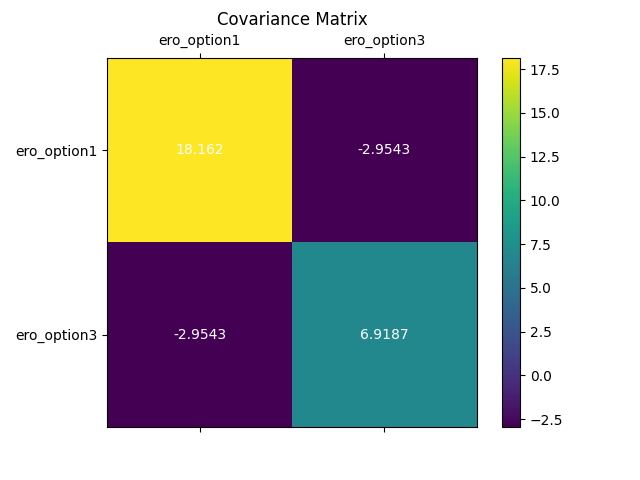

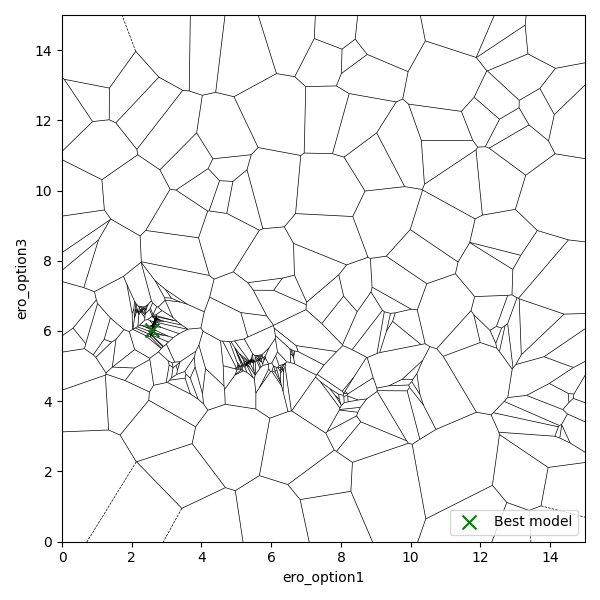

In [12]:
import subprocess
from IPython.display import Image, display

# run inversion
command = [
    "python", "tc1d/tc1d_cli.py",
    "--ero-type", "2",
    "--ero-option1", "0.0", "15.0",
    "--ero-option2", "6.0",
    "--ero-option3", "0.0", "15.0",
    "--ero-option4", "12.0",
    "--time", "12.0",
    "--dt", "20000",
    "--obs-age-file", "tc1d/sample_data.csv",
    "--inverse-mode", "NA"
]

subprocess.run(command)

display(Image("NA_misfit.png"))
display(Image("NA_scatter.png"))
display(Image("NA_covariance_matrix.png"))
display(Image("NA_voronoi.png"))

### Interpretation of the NA Inversion Results

The following plots summarize the output of the Neighbourhood Algorithm (NA) inversion performed with T<sub>c</sub>1D:

1. **Misfit Plot (`NA_misfit.png`)**

   This figure shows the evolution of the model misfit throughout the inversion process.  
   - The first part (left of the dashed line) corresponds to the initial random search.  
   - The second part shows the focused Neighbourhood Search, where the algorithm concentrates on low-misfit regions.  
   A decreasing trend indicates that the inversion progressively identifies better-fitting models.

2. **Scatter Plot of the Sampled Parameter Space (`NA_scatter.png`)**

   This scatter plot shows the sampled parameter space for two erosion parameters (`ero_option1` and `ero_option3`).  
   - The color scale represents the model misfit (lower is better).  
   - The histograms along the top and right axes show the distribution of tested parameter values.  
   - The red cross indicates the best-fitting model identified during the inversion.  
   Clustering of low-misfit points reveals regions of acceptable solutions.

3. **Covariance Matrix of Inverted Parameters (`NA_covariance_matrix.png`)**

   This matrix quantifies the covariance between the inverted parameters.  
   - Large positive values along the diagonal correspond to the variance of each parameter.  
   - Off-diagonal values indicate the degree of correlation between parameters.  
   - For example, a negative covariance suggests an inverse relationship between two parameters.  
   Understanding parameter correlation is essential for interpreting inversion uncertainties.

4. **Voronoi Diagram of the Parameter Space (`NA_voronoi.png`)**

   This plot provides a geometrical visualization of the parameter space partitioning based on the sampled models.  
   - Each polygon represents a region of the parameter space associated with a specific sampled model.  
   - The green marker indicates the location of the best-fitting model.  
   This plot highlights how the NA efficiently focuses exploration on promising regions of the parameter space.

## Forward Modeling with Best-Fit Parameters

After completing the inversion, we can now run TC1D in forward mode using the best-fit parameters identified by the Neighbourhood Algorithm.

This allows us to:

- Simulate the thermal evolution of the model based on these optimal parameters.
- Predict synthetic thermochronological ages.
- Compare these predicted ages to the original synthetic dataset.

This comparison provides a direct assessment of how well the inverted model reproduces the observed data and allows us to evaluate the quality of the inversion.


------------------------------ Execution started -------------------------------

--- General model information ---

- Node spacing: 500.0 m
- Total simulation time: 12.0 million years
- Time steps: 600 @ 20000.0 years each
- Solution type: Implicit
- Erosion model: Step-function
- Total erosional exhumation: 8.6 km

--- Calculating initial thermal model ---

- Initial surface heat flow: 47.2 mW/m^2
- Initial Moho temperature: 633.5°C
- Initial Moho depth: 50.0 km
- Initial LAB depth: 125.0 km

--- Calculating transient thermal model (Pass 1/1) ---

- Step   600 of 600 (Time:  12.0 Myr, Erosion rate:  1.00 mm/yr)


--- Final thermal model values ---

- Final surface heat flow: 71.4 mW/m^2
- Final Moho temperature: 629.5°C
- Final Moho depth: 41.4 km
- Final LAB depth: 125.0 km

--- Predicted thermochronometer ages ---

- AHe age: 2.69 Ma (uncorrected age: 1.79 Ma)
- AFT age: 5.61 Ma (Ketcham)
- ZHe age: 6.34 Ma (uncorrected age: 5.10 Ma)
- ZFT age: 11.70 Ma (MadTrax)

--- Predicted an

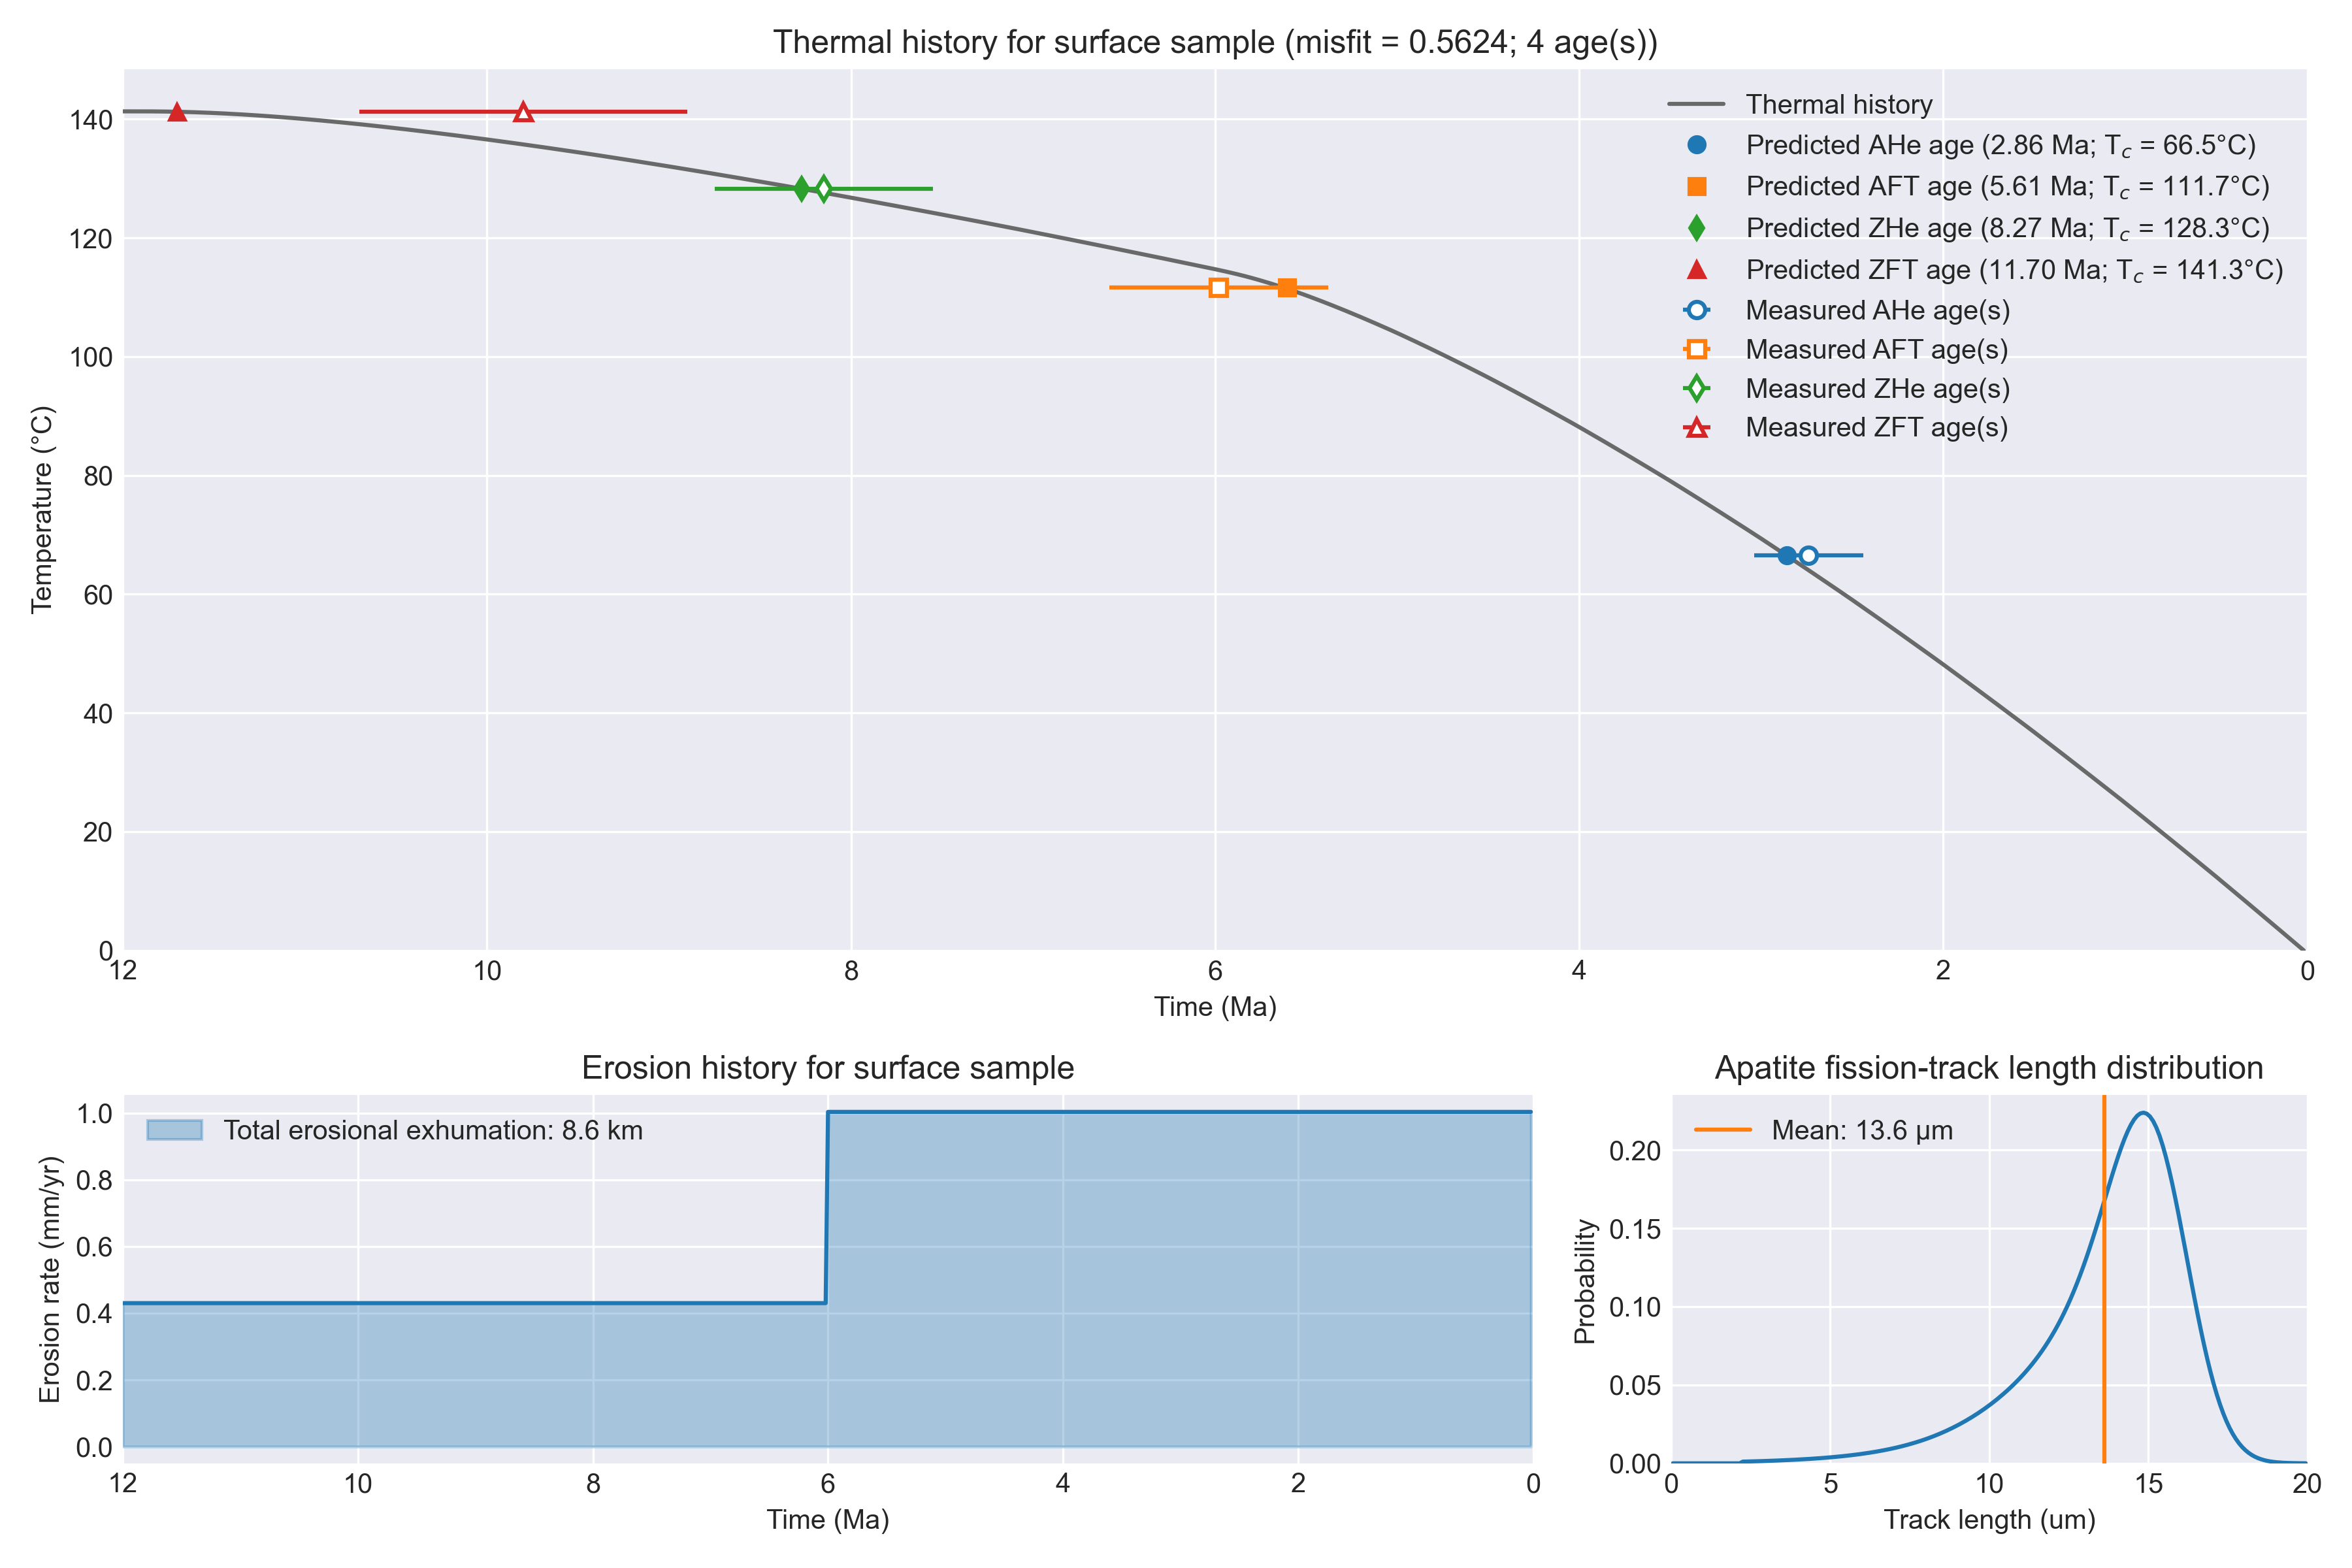

In [13]:
import subprocess
from IPython.display import Image, display

# run forward
command = [
    "python", "tc1d/tc1d_cli.py",
    "--ero-type", "2",
    "--ero-option1", "2.58",# NA inversion should converge around this value
    "--ero-option2", "6.0",
    "--ero-option3", "6.02",# NA inversion should converge around this value
    "--ero-option4", "12.0",
    "--time", "12.0",
    "--dt", "20000",
    "--obs-age-file", "tc1d/sample_data.csv",
    "--save-plots",
]

subprocess.run(command)

display(Image("png/cooling_hist.png"))

# Running T<sub>c</sub>1D inversion using the MCMC algorithm (MCMC)

## Preparing to run an inversion

Before starting, **you must run the code cell below first** to load the T<sub>c</sub>1D code into memory. Note that lines starting with the `#` character are comment lines that can be used for documentation, but are not executed as Python commands.

In [14]:
# import TC1D
import sys
sys.path.append('tc1d')
import tc1d

## Running a Markov Chain Monte Carlo (MCMC) Inversion

The following code cell performs an inversion of the synthetic dataset using the Markov Chain Monte Carlo (MCMC) algorithm implemented in T<sub>c</sub>1D. The process should take few dozen of minutes.

The inversion is launched via a command-line call to the `tc1d_cli.py` script, specifying:

- The erosion model type (`--ero-type`)
- The erosion history parameters (`--ero-option1` to `--ero-option4`)
- The total model time and time step (`--time`, `--dt`)
- The input dataset (`--obs-age-file`)
- The inversion mode (`MCMC` in this case)

Once the inversion is complete, a series of plots are generated and saved in the current directory. The cell then displays these plots directly in the notebook for easy inspection:

- **Misfit plot**: model misfit evolution
- **Chains plot**: walker chains for each parameter (diagnostic of convergence)
- **Corner plot**: posterior distribution of parameters and correlations
- **Scatter plot**: parameter space exploration

### Example Inversion Parameters

The inversion performed in this example uses the following erosion history parameters and model configuration:

| Parameter         | Value(s)      | Description                                           |
|-------------------|---------------|-------------------------------------------------------|
| `--ero-type`      | 2             | Erosion model type                                    |
| `--ero-option1`   | 0.0 to 15.0   | First erosion magnitude: parameter range (km)         |
| `--ero-option2`   | 6.0           | First erosion event: fixed time (Ma)                  |
| `--ero-option3`   | 0.0 to 15.0   | Second erosion magnitude: parameter range (km)        |
| `--ero-option4`   | 12.0          | Second erosion event: fixed time (Ma)                 |
| `--time`          | 12.0          | Total model time (Ma)                                 |
| `--dt`            | 20000         | Time step for forward model (years)                   |
| `--obs-age-file`  | `tc1d/sample_data.csv` | Path to input dataset                     |
| `--inverse-mode`  | MCMC          | Inversion mode: Markov Chain Monte Carlo              |

**Note**: Some parameters are defined as ranges (e.g., `0.0 to 15.0`) to allow the inversion algorithm to explore possible values within those limits. Other parameters are fixed.

### MCMC Settings

The Markov Chain Monte Carlo (MCMC) algorithm is a probabilistic method that explores the parameter space by simulating random walks (chains) of multiple "walkers" and estimating the posterior distribution of model parameters.

In the T<sub>c</sub>1D implementation, MCMC is handled using the [`emcee`](https://emcee.readthedocs.io/) package, with optional parallelization using MPI.

The following settings control the MCMC run:

| Parameter   | Value | Description                                                   |
|-------------|--------|---------------------------------------------------------------|
| `nwalkers`  | 8      | Number of walkers (independent chains)                        |
| `nsteps`    | 300    | Number of steps per walker                                    |
| `discard`   | 50     | Number of initial steps to discard as "burn-in"               |
| `thin`      | 3      | Thinning factor: only every 3rd step is retained in the chain |

**Important**: These settings are currently defined directly in the `tc1d.py` script. To modify them, you need to edit the source code. Future versions may expose these parameters via command-line options.


--- Starting batch processor for 4 models ---

--- Starting MCMC inverse mode ---

- Running MCMC in serial mode
[MCMC] Testing params: {'ero_option1': 14.840822313467713, 'ero_option3': 9.266039021151277}
..........Misfit: 3.1559943695616006
[MCMC] Testing params: {'ero_option1': 9.776186050810441, 'ero_option3': 1.3665831908893118}
..........Misfit: 3.402686073089559
[MCMC] Testing params: {'ero_option1': 5.952044697434937, 'ero_option3': 14.541271668693202}
..........Misfit: 3.88475124669818
[MCMC] Testing params: {'ero_option1': 10.681437471435105, 'ero_option3': 3.3736627783245825}
..........Misfit: 1.4271526182967527
[MCMC] Testing params: {'ero_option1': 8.877635696025148, 'ero_option3': 11.884398031626748}
..........Misfit: 3.4784482104056744
[MCMC] Testing params: {'ero_option1': 12.31398788636039, 'ero_option3': 9.730382552985043}
..........Misfit: 3.12775210473125
[MCMC] Testing params: {'ero_option1': 13.682980567532756, 'ero_option3': 7.565396979714769}
..........Misfit: 2

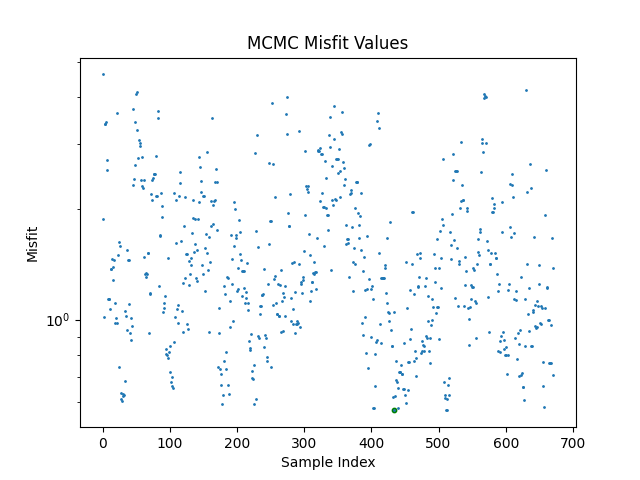

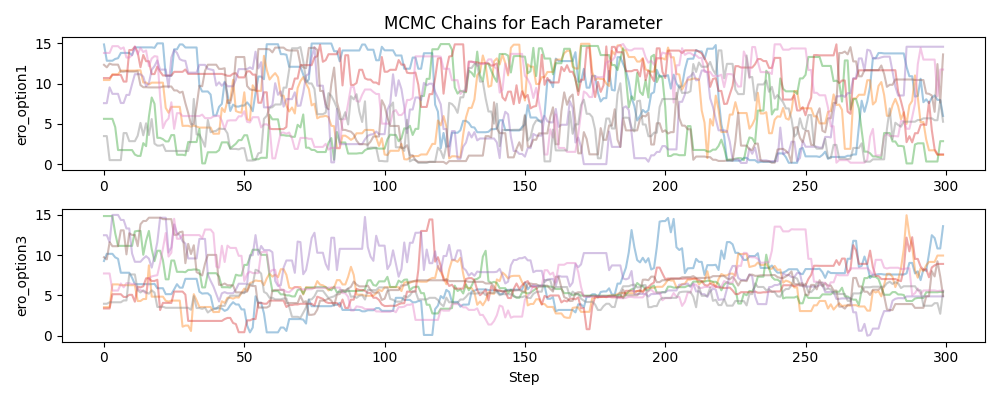

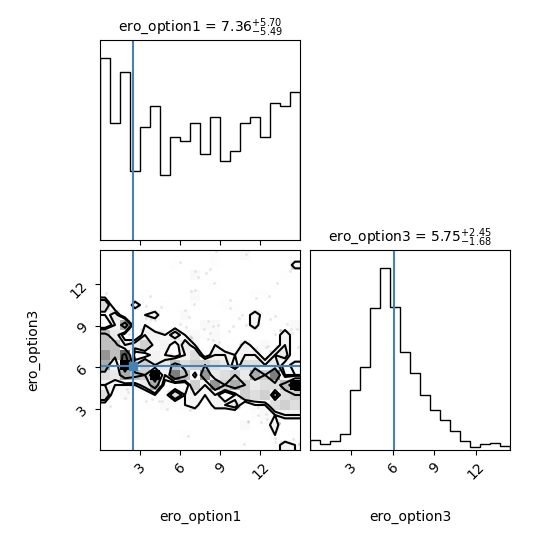

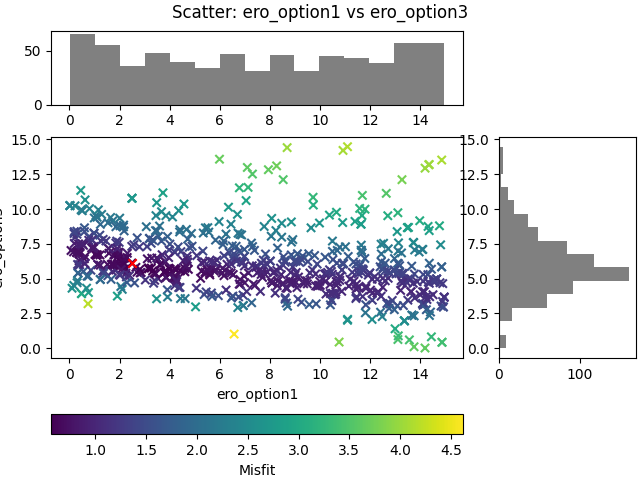

In [15]:
import subprocess
from IPython.display import Image, display

# run inversion
command = [
    "python", "tc1d/tc1d_cli.py",
    "--ero-type", "2",
    "--ero-option1", "0.0", "15.0",
    "--ero-option2", "6.0",
    "--ero-option3", "0.0", "15.0",
    "--ero-option4", "12.0",
    "--time", "12.0",
    "--dt", "20000",
    "--obs-age-file", "tc1d/sample_data.csv",
    "--inverse-mode", "MCMC"
]

subprocess.run(command)

display(Image("mcmc_misfit.png"))
display(Image("mcmc_chains.png"))
display(Image("mcmc_corner.png"))
display(Image("mcmc_scatter_ero_option1_vs_ero_option3.png"))

### Interpretation of the MCMC Inversion Results

The following plots summarize the output of the Markov Chain Monte Carlo (MCMC) inversion performed with T<sub>c</sub>1D:

1. **Chains Plot for Each Parameter (`mcmc_chains.png`)**  
   This figure displays the evolution of sampled values for each parameter over the course of the MCMC simulation.  
   - Each colored line corresponds to a walker.  
   - The x-axis represents the iteration step; the y-axis shows the parameter value.  
   - Well-mixed and overlapping chains suggest good convergence.  
   Visual inspection helps diagnose whether the chains are stuck or have reached stationarity.

2. **Corner Plot (`mcmc_corner.png`)**  
   This figure shows the marginal posterior distributions and pairwise joint distributions of the inverted parameters.  
   - The 1D histograms (top) represent the distribution of each parameter.  
   - The 2D contour plots reveal parameter correlations.  
   - The blue lines indicate the median values with 1σ uncertainties.  
   This plot provides a compact summary of uncertainty and correlation in parameter estimates.

3. **Misfit Plot (`mcmc_misfit.png`)**  
   This scatter plot shows the misfit values associated with all sampled models.  
   - The y-axis is plotted on a log scale for clarity.  
   - The green dot marks the model with the lowest misfit.  
   This plot helps visualize the distribution and density of acceptable solutions.

4. **Scatter Plot of Sampled Parameter Space (`mcmc_scatter_ero_option1_vs_ero_option3.png`)**  
   This plot shows how the MCMC sampled the parameter space of two erosion parameters (`ero_option1` and `ero_option3`).  
   - The color scale represents misfit (darker = better fit).  
   - Histograms show the marginal distributions of each parameter.  
   - The red cross marks the best-fitting model.  
   This visualization is useful for identifying well-constrained regions and parameter trade-offs.

## Forward Modeling with Best-Fit Parameters

After completing the inversion, we can now run TC1D in forward mode using the best-fit parameters identified by MCMC.

This allows us to:

- Simulate the thermal evolution of the model based on these optimal parameters.
- Predict synthetic thermochronological ages.
- Compare these predicted ages to the original synthetic dataset.

This comparison provides a direct assessment of how well the inverted model reproduces the observed data and allows us to evaluate the quality of the inversion.


------------------------------ Execution started -------------------------------

--- General model information ---

- Node spacing: 500.0 m
- Total simulation time: 12.0 million years
- Time steps: 600 @ 20000.0 years each
- Solution type: Implicit
- Erosion model: Step-function
- Total erosional exhumation: 8.6 km

--- Calculating initial thermal model ---

- Initial surface heat flow: 47.2 mW/m^2
- Initial Moho temperature: 633.5°C
- Initial Moho depth: 50.0 km
- Initial LAB depth: 125.0 km

--- Calculating transient thermal model (Pass 1/1) ---

- Step   600 of 600 (Time:  12.0 Myr, Erosion rate:  1.02 mm/yr)


--- Final thermal model values ---

- Final surface heat flow: 71.7 mW/m^2
- Final Moho temperature: 629.6°C
- Final Moho depth: 41.4 km
- Final LAB depth: 125.0 km

--- Predicted thermochronometer ages ---

- AHe age: 2.64 Ma (uncorrected age: 1.76 Ma)
- AFT age: 5.49 Ma (Ketcham)
- ZHe age: 6.24 Ma (uncorrected age: 5.02 Ma)
- ZFT age: 11.70 Ma (MadTrax)

--- Predicted an

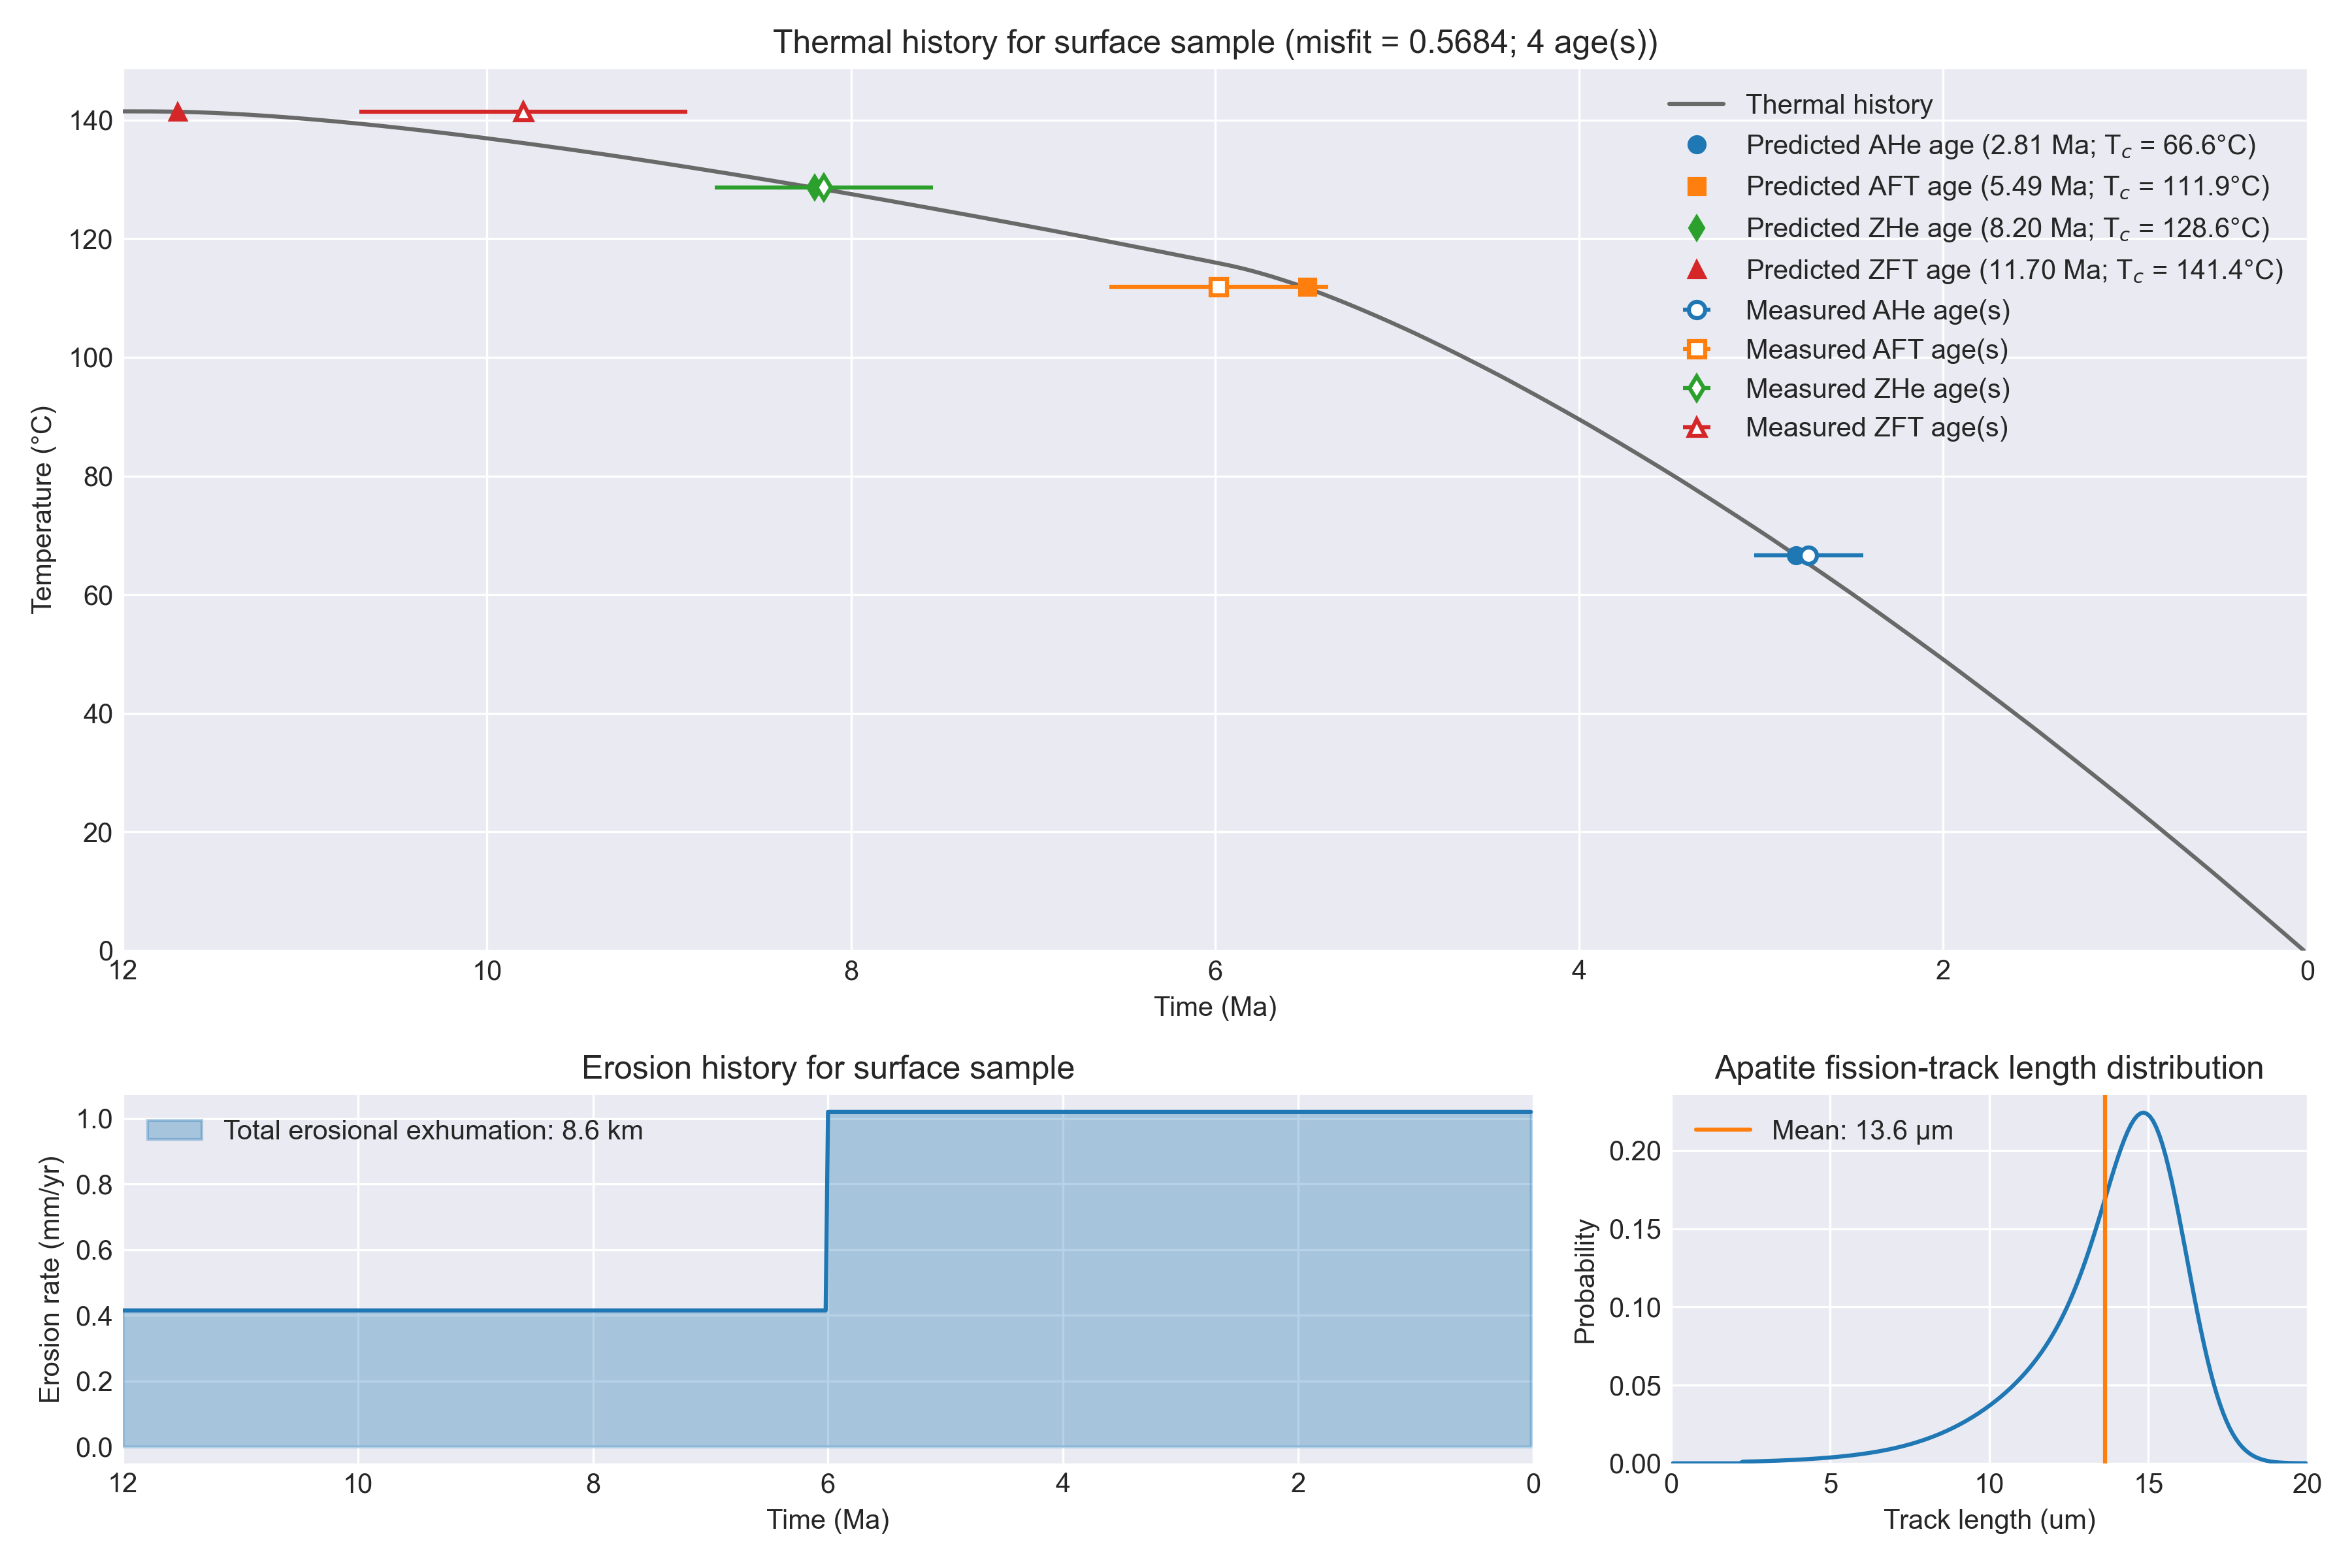

In [17]:
import subprocess
from IPython.display import Image, display

# run forward
command = [
    "python", "tc1d/tc1d_cli.py",
    "--ero-type", "2",
    "--ero-option1", "2.49",# MCMC inversion should converge around this value
    "--ero-option2", "6.0",
    "--ero-option3", "6.12",# MCMC inversion should converge around this value
    "--ero-option4", "12.0",
    "--time", "12.0",
    "--dt", "20000",
    "--obs-age-file", "tc1d/sample_data.csv",
    "--save-plots",
]

subprocess.run(command)

display(Image("png/cooling_hist.png"))